In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import graphviz
import pandas as pd
import torch
from torch import nn
from models import LrpNetwork
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from util import weight_copy, plot_hist, df_append, plot_time_dist
from tqdm import tqdm
from itertools import zip_longest
from datetime import datetime
from torch.nn.functional import normalize

In [3]:
plt.rc('mathtext', **{'fontset' : 'dejavuserif'})

In [4]:
torch.manual_seed(1);
torch.set_num_threads(1);

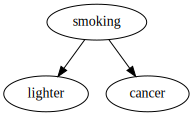

In [5]:
graphviz.Source("""
    digraph {
        smoking -> lighter
        smoking -> cancer
    }
""")

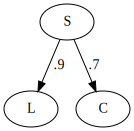

In [6]:
graphviz.Source("""
    digraph {
        S -> L [label=".9"]
        S -> C [label=".7"]
    }
""")

In [7]:
N = 5_000
def generate_observations(seed=13, N=N):
    np.random.seed(seed=seed)
    S = np.random.random(size=N) - .5
    L = .9 * S + .1 * (np.random.random(size=N) - .5)
    C = .7 * S + .3 * (np.random.random(size=N) - .5)

    return pd.DataFrame(np.c_[S, L, C], columns=list("SLC"))
df = generate_observations()
df

,S,L,C
0,0.277702,0.254144,0.137969
1,-0.262459,-0.277578,-0.226507
2,0.324279,0.292176,0.112694
3,0.465749,0.371633,0.243419
4,0.472601,0.413287,0.242303
...,...,...,...
4995,0.146900,0.161877,0.033370
4996,-0.007327,0.000756,-0.013352
4997,0.070385,0.026599,0.044288
4998,0.351831,0.346465,0.186678


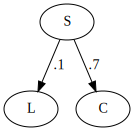

In [8]:
graphviz.Source("""
    digraph {
        S -> L [label=".1"]
        S -> C [label=".7"]
    }
""")

In [9]:
# Soft intervention, lowers correlation between S 
def generate_intervened_observations(seed=17, N=N):
    np.random.seed(seed)
    S = np.random.random(size=N) - .5
    L = .1 * S + .9 * (np.random.random(size=N) - .5)
    C = .7 * S + .3 * (np.random.random(size=N) - .5)

    return pd.DataFrame(np.c_[S, L, C], columns=list("SLC"))
df_intervened = generate_intervened_observations()
df_intervened

,S,L,C
0,-0.205335,0.157506,-0.247516
1,0.030587,-0.123046,-0.126321
2,-0.308479,-0.416464,-0.205112
3,-0.432100,-0.466209,-0.293491
4,0.286985,0.400011,0.191020
...,...,...,...
4995,-0.480191,-0.213472,-0.206898
4996,0.269511,0.173375,0.101931
4997,-0.389593,-0.015360,-0.355913
4998,-0.320314,0.270800,-0.206786


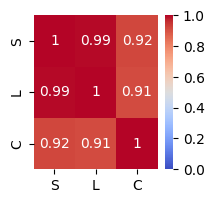

In [10]:
plt.figure(figsize=(2,2))
sns.heatmap(df.corr(), cmap="coolwarm", annot=True, vmin=0., vmax=1.);

In [11]:
df.corr().style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2)

,S,L,C
S,1.00,0.99,0.92
L,0.99,1.00,0.91
C,0.92,0.91,1.00


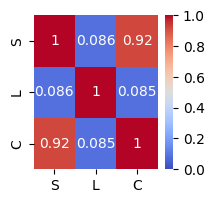

In [12]:
plt.figure(figsize=(2,2))
sns.heatmap(df_intervened.corr(), cmap="coolwarm", annot=True, vmin=0., vmax=1.);

In [13]:
df_intervened.corr().style.background_gradient(cmap='coolwarm', vmin=0, vmax=1).format(precision=2)

,S,L,C
S,1.00,0.09,0.92
L,0.09,1.00,0.09
C,0.92,0.09,1.00


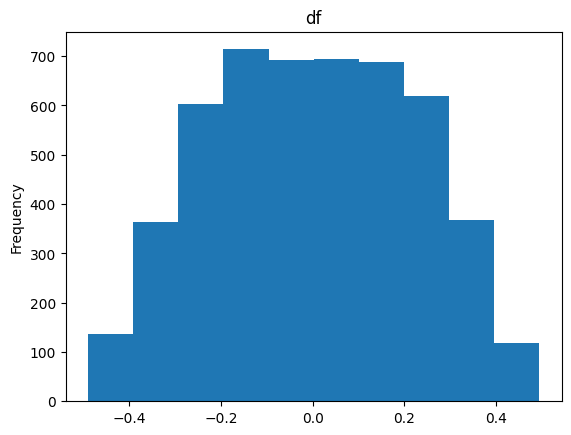

In [14]:
df["C"].plot.hist(title="df"); 

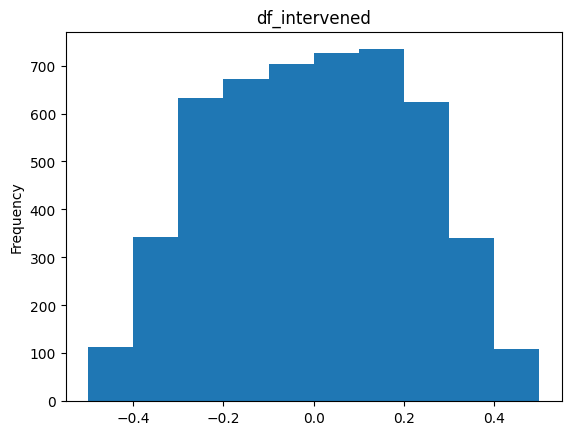

In [15]:
df_intervened["C"].plot.hist(title="df_intervened");

In [16]:
df.describe()

,S,L,C
count,5000.000000,5000.000000,5000.000000
mean,0.001149,0.001754,0.001012
std,0.287739,0.260378,0.219671
min,-0.499998,-0.496153,-0.489350
25%,-0.253319,-0.226978,-0.171480
50%,0.000878,0.004188,0.000199
75%,0.246608,0.222144,0.179973
max,0.499980,0.490456,0.493837


In [17]:
df_intervened.describe()

,S,L,C
count,5000.000000,5000.000000,5000.000000
mean,0.001643,-0.009099,0.001294
std,0.287074,0.260371,0.217824
min,-0.499944,-0.492828,-0.498840
25%,-0.244239,-0.229675,-0.174356
50%,0.006532,-0.017843,0.004602
75%,0.247356,0.215057,0.175003
max,0.499797,0.489696,0.498759


##### Create Test & Training-Dataloaders

In [18]:
batch_size = 512
def get_dataloader(df, batch_size=batch_size):
    S = df[["S", "L"]].astype(np.float32).values
    y = (df["C"] > 0.).astype(np.int64).values
    ds = TensorDataset(torch.tensor(S), torch.tensor(y))
    return DataLoader(ds, batch_size=batch_size)

def get_train_test_dataloaders(df, split=.8):
    idx_train = df.index[:int(split * len(df))]
    idx_test = df.index.difference(idx_train)
    return get_dataloader(df.loc[idx_train]), get_dataloader(df.loc[idx_test])

train_dl, test_dl = get_train_test_dataloaders(df)

##### Create common and attributed Neural Network

In [19]:
class NonInformedNetwork(LrpNetwork):
    "We use the LrpNetwork class, to track LRP-values, but do not apply a penalty."
    def __init__(self, *args, **kwargs):
        super(NonInformedNetwork, self).__init__(*args)

class CimlrNetwork(LrpNetwork):
    "We use the LrpNetwork class, to track LRP-values to apply a penalty."
    def __init__(self, *args, **kwargs):
        super(CimlrNetwork, self).__init__(*args)

def generate_layers(nr_features):
    """
    Create a list of linear layers followed by ReLUs.
    Note: Same layers in different nets result in interference!
    """
    linear_layers = [nn.Linear(in_, out_) for in_, out_ in zip(nr_features[:-1], nr_features[1:])]
    # zip Linear and ReLU layers (put a ReLU between each pair of Linear layers)
    layer_tuples = zip_longest(linear_layers, [nn.ReLU()] * (len(linear_layers) - 1))
    # flatten
    return [layer for layertuple in layer_tuples for layer in layertuple if layer is not None]

def generate_models(cimlr_model_type, nr_features=[2,7,7,2]):

    if cimlr_model_type == "LRP":
        # LRP att. model
        layers = generate_layers(nr_features)
        cimlr_model = CimlrNetwork(*layers)
    else:
        raise NotImplementedError("Model type '{}' not implemented!".format(cimlr_model_type))

    # conventional model
    layers = generate_layers(nr_features)

    ni_model = NonInformedNetwork(*layers)
    
    # align weights
    weight_copy(ni_model, cimlr_model)

    return cimlr_model, ni_model

cimlr_model_type = "LRP"
cimlr_model, ni_model = generate_models(cimlr_model_type, nr_features=[2,7,7,2])
print(cimlr_model)
print(ni_model)

CimlrNetwork(
  (0): Linear(in_features=2, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=2, bias=True)
)
NonInformedNetwork(
  (0): Linear(in_features=2, out_features=7, bias=True)
  (1): ReLU()
  (2): Linear(in_features=7, out_features=7, bias=True)
  (3): ReLU()
  (4): Linear(in_features=7, out_features=2, bias=True)
)


In [20]:
def train_loop(dataloader, model, loss_fn_, optimizer, verbose=False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        if isinstance(model, NonInformedNetwork):
            loss = loss_fn_(pred, y)
        else:
            loss = loss_fn_(pred, y, model) # (B, C), (B) --> B

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose == True:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn_, verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    atts = np.array([[],[]])

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            if isinstance(model, NonInformedNetwork):
                test_loss += loss_fn_(pred, y).item()
            else:
                test_loss += loss_fn_(pred, y, model).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            if isinstance(model, LrpNetwork):
                model_att = model.relevance.T
                atts = np.concatenate((atts, model_att), axis=1)

    test_loss /= num_batches
    correct /= size
    if verbose == True:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        
    return test_loss, correct, atts

In [21]:
test_intervened_dl = get_dataloader(df_intervened, batch_size=batch_size)

##### Train attributed NN

In [22]:
learning_rate = 1e-2
epochs = 500
loss_fn = nn.CrossEntropyLoss()
cimlr_optimizer = torch.optim.SGD(cimlr_model.parameters(), lr=learning_rate)
target_attribution = torch.tensor([1.0, 0.0])
# we set lambda to 1. 
experiment_name = "_MAE300_2_7_7_2_LRP-0_lambda_1_incl_ni_att" # use this to mark special experiments in result files
lambda_ = 1.

def cimlr_loss_fn(pred, y, model):
    return (
        loss_fn(pred, y) + 
        lambda_ * (
            target_attribution
            - normalize(model.relevance, dim=1)
        ).abs().mean()
    )

def train(model, 
          loss_fn_, 
          optimizer_, 
          train_dl, 
          test_dl, 
          intervened_test_dl=None, 
          epochs=epochs, 
          verbose=False,
          show_tqdm=True
         ):
    losses = []
    accs = []
    int_accs = []
    atts = []
    if show_tqdm == True:
        pbar = tqdm(range(epochs))
    else:
        pbar = range(epochs)
    for t in pbar:
        train_loop(
            train_dl, 
            model, 
            loss_fn_, 
            optimizer_
        )
        loss, acc, model_att = test_loop(test_dl, model, loss_fn_)
        if intervened_test_dl is not None:
            _, intervened_acc, _ = test_loop(intervened_test_dl, model, loss_fn_)
        pbar_desc = f"Epoch: {(t+1):>3d}, Accuracy: {(acc * 100):>0.1f}, Loss: {loss:>8f}"
        if show_tqdm:
            pbar.set_description(pbar_desc)
        losses.append(loss)
        accs.append(acc)
        if isinstance(model, LrpNetwork):
            atts.append(model_att) 
        if intervened_test_dl is not None:
            int_accs.append(intervened_acc)
    if verbose:
        print("Done!")
    if intervened_test_dl is not None:
        return losses, accs, np.array(atts), int_accs
    else:
        return losses, accs, np.array(atts)
losses, accs, atts, int_accs = train(cimlr_model, cimlr_loss_fn, cimlr_optimizer, train_dl, test_dl, intervened_test_dl=test_intervened_dl);

Epoch: 500, Accuracy: 89.1, Loss: 0.620804: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.57it/s]


In [23]:
loss, acc, _ = test_loop(test_dl, cimlr_model, cimlr_loss_fn, verbose=True)

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.620804 



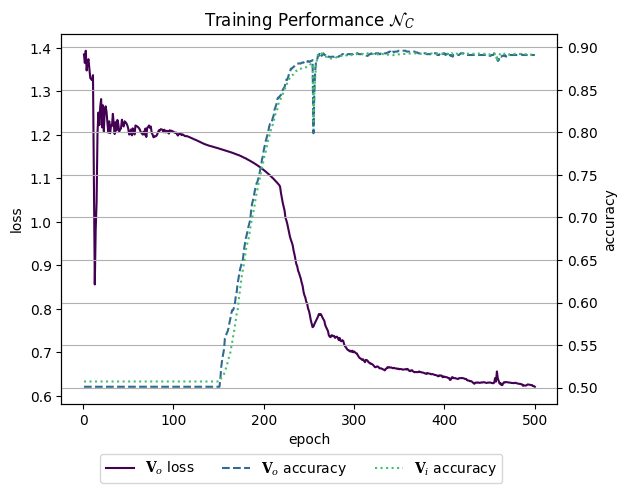

In [24]:
fig, legend = plot_hist(losses, accs, intervened_accs=int_accs, plot_legend=True, model_name=r"$\mathcal{N}_C$");
fig.savefig("figures/cimlr_training_performance.svg", format="svg", bbox_extra_artists=(legend,), bbox_inches='tight')

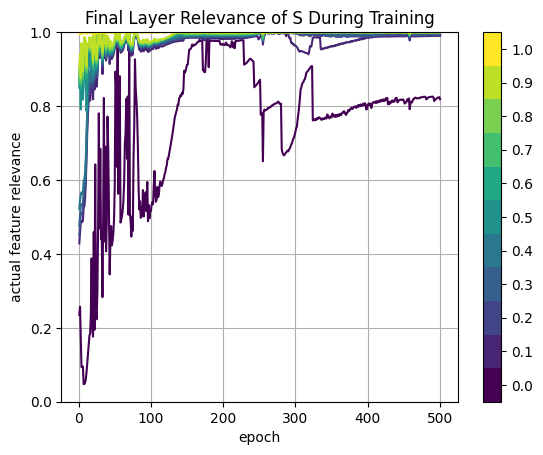

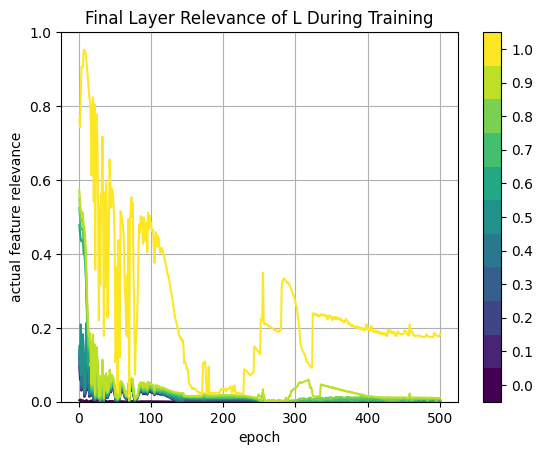

In [25]:
if len(atts) > 0:
    for i, name in enumerate(("S", "L")):
        if isinstance(cimlr_model, LrpNetwork):
            atts = atts / np.clip(np.abs(atts).sum(axis=1)[:,None,:], 1e-12, None)
        plot_time_dist(np.abs(atts[:,i,:].T), f"Final Layer Relevance of {name} During Training", "actual feature relevance");
        if isinstance(cimlr_model, LrpNetwork):
            plt.ylim(top=1, bottom=0)

##### Train common neural network

In [26]:
loss_fn = nn.CrossEntropyLoss()
ni_optimizer = torch.optim.SGD(ni_model.parameters(), lr=learning_rate)

losses, accs, atts, int_accs = train(ni_model, loss_fn, ni_optimizer, train_dl, test_dl, intervened_test_dl=test_intervened_dl);

Epoch: 500, Accuracy: 88.8, Loss: 0.230415: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:24<00:00, 20.70it/s]


In [27]:
loss, acc, _ = test_loop(test_dl, ni_model, loss_fn, verbose=True)

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.230415 



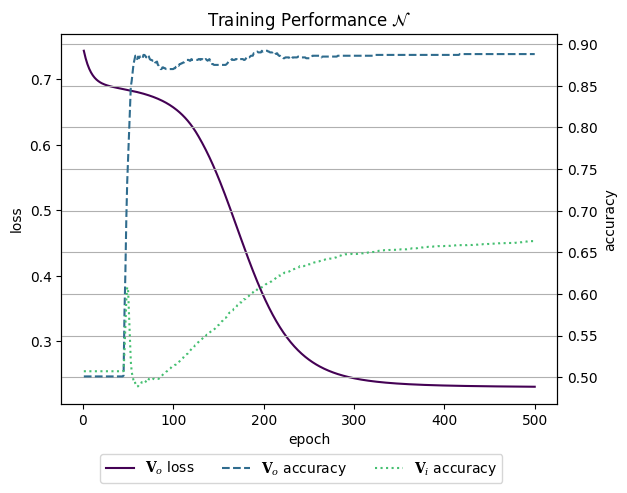

In [28]:
fig, legend = plot_hist(losses, accs, intervened_accs=int_accs, plot_legend=True, model_name=r"$\mathcal{N}$");
fig.savefig("figures/ni_training_performance.svg", format="svg", bbox_extra_artists=(legend,), bbox_inches="tight")

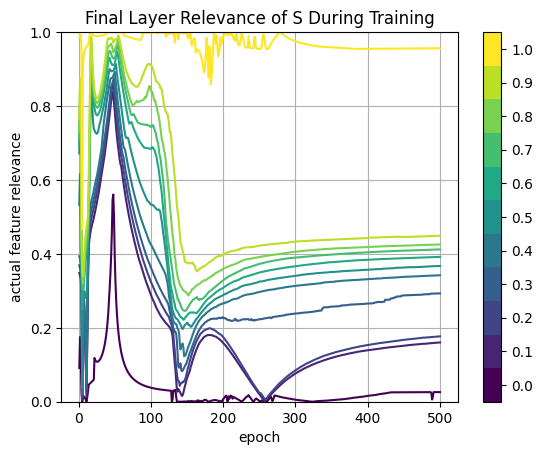

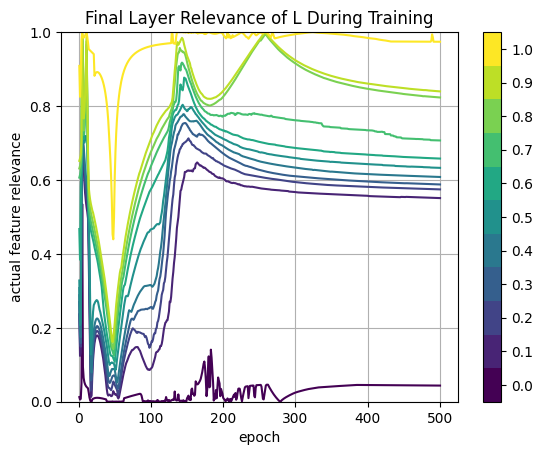

In [29]:
if len(atts) > 0:
    for i, name in enumerate(("S", "L")):
        if isinstance(cimlr_model, LrpNetwork):
            atts = atts / np.clip(np.abs(atts).sum(axis=1)[:,None,:], 1e-12, None)
        plot_time_dist(np.abs(atts[:,i,:].T), f"Final Layer Relevance of {name} During Training", "actual feature relevance");
        if isinstance(cimlr_model, LrpNetwork):
            plt.ylim(top=1, bottom=0)

Test accuracy of a baseline estimator: $\hat{y} := x \gt 0$

In [30]:
acc = 0. 
dl = test_dl
for X, y in dl:
    batch_acc = np.array((((X[:, 0] > 0.).tolist())) == np.array(y)).mean()
    acc += batch_acc
"overall accuracy of x > 0:", acc / len(dl)

('overall accuracy of x > 0:', 0.8902247694672132)

##### Test Performance on intervened dataset

In [31]:
test_loop(test_intervened_dl, cimlr_model, cimlr_loss_fn, verbose=True);

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.529980 



In [32]:
test_loop(test_intervened_dl, ni_model, loss_fn, verbose=True);

Test Error: 
 Accuracy: 66.3%, Avg loss: 0.735201 

